# 1) Dataset Explanation:

 1. **label** : contains the disease labels
 2. **text** : contains the natural language symptom descriptions.

 The dataset comprises **24 different diseases**, and each disease has **50 symptom descriptions**, resulting in a total of **1200 datapoints**.
 
 The following 24 diseases have been covered in the dataset:
 Psoriasis, Varicose Veins, Typhoid, Chicken pox, Impetigo, Dengue, Fungal infection, Common Cold, Pneumonia, Dimorphic Hemorrhoids, Arthritis, Acne, Bronchial Asthma, Hypertension, Migraine, Cervical spondylosis, Jaundice, Malaria, urinary tract infection, allergy, gastroesophageal reflux disease, drug reaction, peptic ulcer disease, diabetes.

In [125]:
import pandas as pd
dataset = pd.read_csv("Symptom2Disease.csv")
dataset.head(5)

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


# 2) EDA

To do the Exploratory Data Analysis it's important to tokenize the corpora first.

In [126]:
from nltk.tokenize import word_tokenize
from nltk import download
#download('punkt_tab')
def tokenization(corpora):
    tokens = []
    for doc in corpora:
        tokenized = [word for word in word_tokenize(doc.lower())]
        tokens.append(tokenized)
    return tokens

In [127]:
tokens = tokenization(dataset["text"])

Let's analyze the stats on our tokenized corpora

In [128]:
def corporaStats(tokens):
    n_words = 0
    for doc in tokens:
        n_words += len(doc)


    unique_words = set()
    for doc in tokens:
        unique_words.update(doc)

    n_unique_words = len(unique_words)
    return n_words, n_unique_words

In [129]:
n_words, n_unique_words = corporaStats(tokens)
freq_unique = n_unique_words/n_words
print(f"Number of words: {n_words}\n")
print(f"Number of unique words: {n_unique_words}\n")
print(f"Percentage of unique words: {freq_unique*100:3.1f}%")

Number of words: 43421

Number of unique words: 1570

Percentage of unique words: 3.6%


Let's analyze the frequency of words

In [130]:
from nltk import FreqDist
def frequency(tokens, nWords = 10, text = ""):
    freq = FreqDist([word for doc in tokens for word in doc])
    freq.plot(nWords, title = text)
    return freq

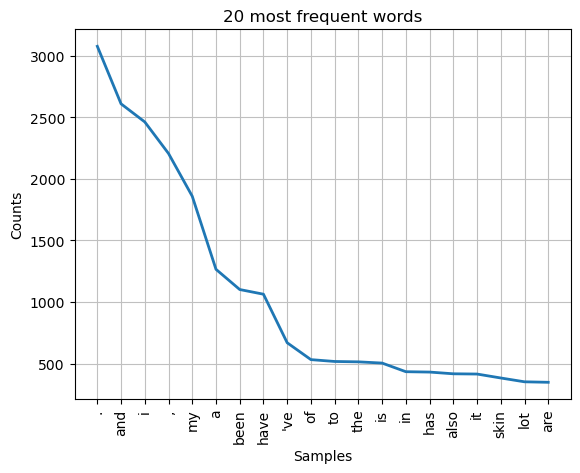

In [131]:
freq = frequency(tokens, 20, "20 most frequent words")

As we can see, punctuation can cause some problems in the interpretation of important words. 

"have" and "’ve" is the same verb, so after, it’s important to remove the punctuation and give the verbs the same form. 

Another cleaning we can do, is to remove the stop words (as we can see they have a high frequency), in this way we put effort on words that can make a difference in the accuracy of the problem

Now it is important to understand what are the contracted forms in our corpora. Some forms (e.g "cannot") are already handled correctly by the tokenizer

Text(0, 0.5, 'Density')

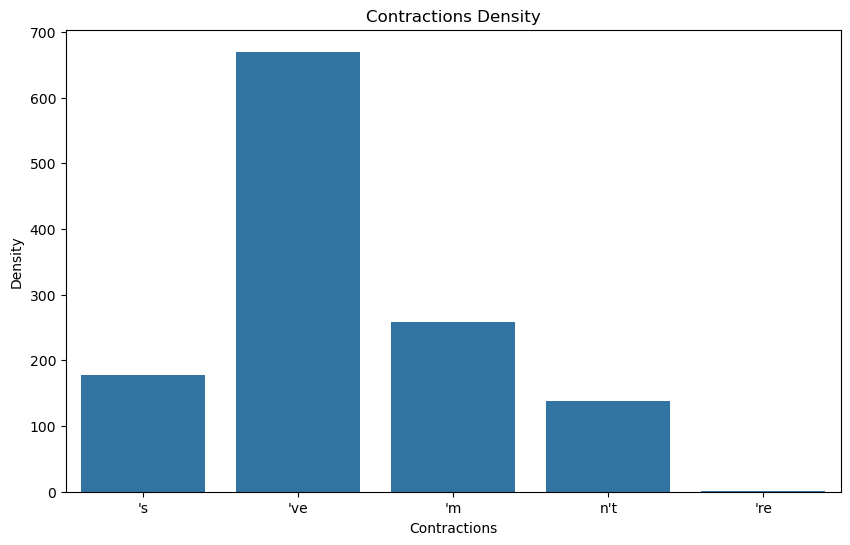

In [207]:
import re
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

cf_reg = re.compile(r".*'[^\W].*")
corpus_cf = [token for doc in tokens for token in doc if cf_reg.match(token)]
cf_counts = Counter(corpus_cf)

plt.figure(figsize=(10, 6))
sns.barplot(x=cf_counts.keys(), y=cf_counts.values())
plt.title("Contractions Density")
plt.xlabel("Contractions")
plt.ylabel("Density")

Now it's important to check some particular contractions with n't.
For example:
  1) "don't" = "do","n't" 
  2) "won't" = "wo", "n't"
  3) "shan't" = "sha", "n't" 
  4) "can't" = "ca", "n't"
   
wo and sha have no meaning, so we need to handle this in order to not have meaningless words in the final results.

Let's check if this two forms are present.

Text(0, 0.5, 'Density')

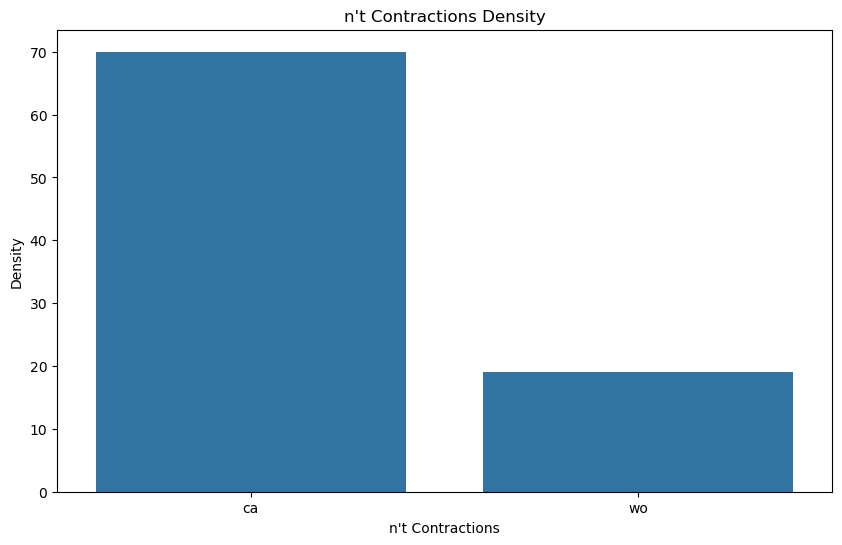

In [133]:
nt_reg = re.compile(r"^(wo|sha|ca)$")
corpus_nt = [token for doc in tokens for token in doc if nt_reg.match(token)]
nt_counts = Counter(corpus_nt)

plt.figure(figsize=(10, 6))
sns.barplot(x=nt_counts.keys(), y=nt_counts.values())
plt.title("n't Contractions Density")
plt.xlabel("n't Contractions")
plt.ylabel("Density")

# 3) Preprocessing

Considering the above analysis, it's important to remove the puntctuation, stopwords and adjust the contractions. Antoher thing that it's important to notice, is that in this corpora there is no new slang present, but it's a formal language, so since there are no particular computing requirements either, a good strategy is to use lemmanization 

In [134]:
def removeContractions(token, cf):
     ncf = token
     for reg, sub in cf:
          ncf = re.sub(reg, sub, ncf)
     return ncf

In [135]:
from nltk.corpus import wordnet
#download('wordnet')

#Function that convert the tag into the wordnet tag format
def wordnet_tag(tag):
     if tag.startswith('J'): 
        return wordnet.ADJ
     elif tag.startswith('V'):
        return wordnet.VERB
     elif tag.startswith('N'):
        return wordnet.NOUN
     elif tag.startswith('R'):
        return wordnet.ADV
     else:
        return wordnet.NOUN

In [136]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
#download('averaged_perceptron_tagger_eng')

def preprocessing(tokens, reg = [], stop_words = (), punctuation = ()):
    #WordNet as lematizer
    lemmatizer = WordNetLemmatizer()
    pre_tokens = []
    for doc in tokens: 
        #Assign the pos tags
        tag_token = pos_tag(doc)
        lm = []
        for token, tag in tag_token:
            ncf_token = removeContractions(token, reg)
            lm_token = lemmatizer.lemmatize(ncf_token, wordnet_tag(tag))
            if lm_token not in stop_words and lm_token not in punctuation and lm_token.isalpha():
                lm.append(lm_token)
        pre_tokens.append(lm)
    
    return pre_tokens

It's important now to remove the words we need from the stopwords so that they are not removed from the corpora. In particular we need to remove 'not' since "I have a fever", "I do not have a fever" is different. Then it's important to add to the stopwords also the words that are useless in our case.

Another thing to note is for contracted forms, only those that are not considered stopwords are adjusted and those that will not be removed   with the control with the set of punctuation.

Due to a succesive analysis i noticed that the word "feel" is the most frequent, but this can be tricky. In particular we can notice that the word is present in a lot of sentences, but the use of it depends on how the person expresses himself (e.g: "I always feel sweaty" and "I'm always sweaty").
The idea is to put more effort on the symptom and its level of sensation because it's more likely that the descriptions of the same disease are similar.


![](output.png "Frequency without removing feel")

In [137]:
#download('stopwords')
stop_words = set(stopwords.words("english"))

discard = ["not", "no"]
add = ["also","feel"]
for word in discard:
    stop_words.discard(word)
for word in add:
    stop_words.add(word)

punctuation = set(string.punctuation)
regExp = [ (r"^wo$", "will"), (r"^n't$", "not"), (r"^ca$", "can")]
pre_tokens = preprocessing(tokens, regExp, stop_words, punctuation)

Let's check the results

In [138]:
tokens[601]

['i',
 "'ve",
 'got',
 'a',
 'cough',
 'that',
 'wo',
 "n't",
 'go',
 'away',
 ',',
 'and',
 'i',
 "'m",
 'exhausted',
 '.',
 'i',
 "'ve",
 'been',
 'coughing',
 'up',
 'thick',
 'mucous',
 'and',
 'my',
 'fever',
 'is',
 'also',
 'pretty',
 'high',
 '.']

In [139]:
pre_tokens[601]

['get',
 'cough',
 'not',
 'go',
 'away',
 'exhausted',
 'cough',
 'thick',
 'mucous',
 'fever',
 'pretty',
 'high']

Let's check the stats now

In [140]:
n_words_pre, n_unique_words_pre = corporaStats(pre_tokens)
freq_unique_pre = n_unique_words_pre/n_words_pre
print(f"Number of words: {n_words_pre}. Difference: {n_words-n_words_pre}\n")
print(f"Percentage of unique words: {freq_unique_pre*100:3.1f}%. Difference: {(freq_unique_pre-freq_unique)*100:3.1f}")

Number of words: 17682. Difference: 25739

Percentage of unique words: 7.0%. Difference: 3.4


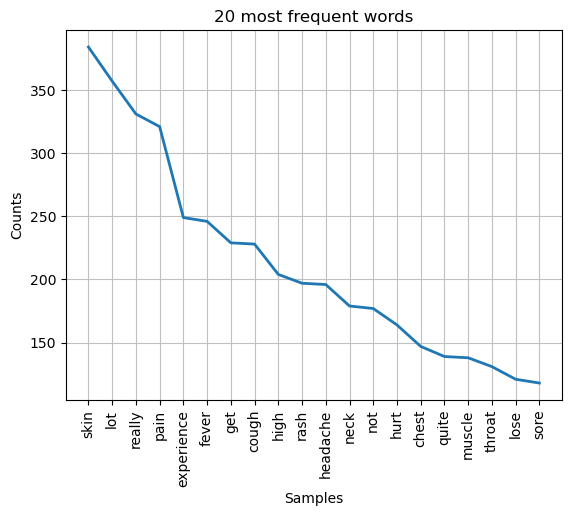

In [141]:
freq_pre = frequency(pre_tokens, 20, "20 most frequent words")

# 4) Models Development

Let's divide the dataset to better analyze performance on unseen data

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pre_tokens, dataset["label"].to_numpy(), test_size=0.2, random_state=21)

### 4.1) CBOW Word2Vec with averaging the embeddings of the words 

This function simply takes the w2v representation of each word in a document and then averages it

In [143]:
from gensim.models.word2vec import Word2Vec
from numpy import zeros, mean

def  w2v_avg(X, model):
    X_emb = []
    for doc in X:
        doc_emb = []
        for token in doc:
            if token in model.wv:
                doc_emb.append(model.wv[token])
        #empty
        if not doc_emb:
            X_emb.append(zeros(model.vector_size))
        else:
            X_emb.append(mean(doc_emb, axis=0))
    
    return X_emb

In [144]:
from sklearn.neighbors import KDTree
model_wv = Word2Vec(X_train, min_count=1, vector_size=100, window=2, workers=-1)
X_train_wv = w2v_avg(X_train, model_wv) 
kdtree_wv = KDTree(X_train_wv)

### 4.2) Doc2Vec

To create this model it's important to assign an id to each document, build a vocabulary and then train the network. In this case, distributed memory is used.

Since the dataset doesn't have a large number of documents and each documents doesn't have a large number of words, it's important to increase the dimensionality of each vector and decrease the window size, in this way we can capture more information and specific local relationships between words.

In [145]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
n_words_train, n_unique_words_train = corporaStats(X_train)
tagged = [TaggedDocument(words=doc, tags=[f"doc{i}"]) for i, doc in enumerate(X_train)]
model_dv = Doc2Vec(min_count=1, vector_size=300, window=2, dm=1)
model_dv.build_vocab(tagged)
model_dv.train(tagged, total_examples=model_dv.corpus_count, epochs=50, total_words=n_words_train)
X_train_dv = [model_dv.infer_vector(doc, epochs=20) for doc in X_train]
kdtree_dv = KDTree(X_train_dv)

### 4.3) TF-IDF Weighted Word Embeddings

This function does the embendding using tf-idf

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
model_tfidf = TfidfVectorizer()
X_train_tfidf = model_tfidf.fit_transform( [" ".join(doc) for doc in X_train]).toarray()
kdtree_tfidf = KDTree(X_train_tfidf)
print(f"Dimension: {len(model_tfidf.vocabulary_)} \n {model_tfidf.vocabulary_}")

Dimension: 1163 
 {'often': 710, 'get': 444, 'aburning': 7, 'sensation': 870, 'throat': 1022, 'especially': 337, 'eat': 316, 'sometimes': 924, 'leave': 570, 'sour': 930, 'bitter': 99, 'taste': 998, 'mouth': 647, 'nauseos': 669, 'beacuse': 83, 'constipate': 201, 'really': 807, 'hard': 465, 'go': 448, 'bathroom': 81, 'hurt': 501, 'stool': 954, 'bloody': 112, 'pain': 725, 'butt': 144, 'anus': 52, 'itchy': 550, 'irritated': 543, 'not': 690, 'mood': 641, 'swallowing': 987, 'difficult': 268, 'linger': 582, 'feeling': 381, 'fullness': 432, 'even': 338, 'little': 586, 'meal': 615, 'typical': 1061, 'symptom': 994, 'include': 513, 'heartburn': 477, 'nausea': 665, 'tingling': 1032, 'along': 40, 'high': 485, 'fever': 385, 'chill': 158, 'vomit': 1112, 'severe': 875, 'itching': 549, 'headache': 469, 'excessive': 346, 'sweating': 989, 'awful': 72, 'muscle': 656, 'ache': 10, 'recurrent': 814, 'blurred': 116, 'vision': 1108, 'suffer': 978, 'acid': 12, 'reflux': 818, 'trouble': 1054, 'digest': 271, 'foo

# 5) Models Evaluation

To evaluate the performance of the retrival we will assess the performance of the classifications. To ensure a better understanding of the performance of the retrival models, we will take the 5 most relevant documents and use a voting system in order to make classifications, in this way it's possible to save even the probabilities.

It's important to note that the number of most relevant is crucial for the classification and for understanding the quality of the search engine. For example if we have 7 samples of a class in the training set and choose n = 11, the performance of the classifications will decrease, also we won't be able to unsdestand if the results with a higher score were correct, with a lower n this is more intuitive

To overcome these problems with the increment of n, I implemented a weighted vote system based on cosine similarity or distance

In [147]:
votes = {label: 0 for label in set(dataset['label'])}
n = 5

def resetVotes(votes):
    for label in votes:
        votes[label] = 0

In [148]:
def ap(retrieved, y_true, y_tree):
    precision_at_k = 0
    num_relevant = 0
    num_correct = 0
    
    for i, item in enumerate(retrieved[0]):
        if y_tree[item] == y_true:
            num_correct += 1
            precision_at_k += num_correct / (i + 1)
            num_relevant += 1
    
    if num_relevant == 0:
        return 0
    else:
        return precision_at_k / num_relevant

def map(retrived, y_true, y_tree):
    score = 0
    for i in range(len(y_true)):
        score += ap(retrived[i], y_true[i], y_tree)
    
    return score/(len(y_true)+1)

### 5.1) Word2Vec with Cosine similarity

In [149]:
from numpy import dot
from numpy.linalg import norm
def cosine_similarity(a, b):
    return dot(a, b)/(norm(a)*norm(b))

The implemented function can be seen as a custom version of knn using cosine similarity, with a weight based on similarity

In [150]:
from numpy import argsort

#Calculate all the predictions and probability
def makeClassificationCosine(X_test, X_train, y_train, votes, n):
    y_out = []
    prob = []
    for doc_ts in X_test:
        similarity = []
        for doc_tr in X_train:
            similarity.append(cosine_similarity(doc_ts, doc_tr))
        topn = argsort(similarity)[-n:]
        normalizer = 0
        for index in topn:
            votes[y_train[index]] += (similarity[index])
            normalizer += (similarity[index])
        y_out.append(max(votes, key=votes.get))
        prob.append([votes[label]/normalizer for label in votes])
        resetVotes(votes)

    return y_out, prob
    

Let's evaluate the performance.
A previous analysis without the weight based on the similarity showed that the macro awg was:
- n = 3 : 0.87 | 0.88 | 0.87 
- n = 5 : 0.86 | 0.87 | 0.86
- n = 11 : 0.80 | 0.80 | 0.78

With the weights:
- n = 3 : 0.88 | 0.88 | 0.88
- n = 5 : 0.89 | 0.89 | 0.88
- n = 11 : 0.86 | 0.86 | 0.86

In [151]:
from sklearn.metrics import classification_report
X_test_wv = w2v_avg(X_test, model_wv)
y_out_wv, prob_wv = makeClassificationCosine(X_test_wv, X_train_wv, y_train, votes, n)
print(classification_report(y_test, y_out_wv))

                                 precision    recall  f1-score   support

                           Acne       0.91      1.00      0.95        10
                      Arthritis       0.86      1.00      0.92        12
               Bronchial Asthma       0.73      0.80      0.76        10
           Cervical spondylosis       0.88      1.00      0.93         7
                    Chicken pox       1.00      0.89      0.94         9
                    Common Cold       0.82      0.82      0.82        11
                         Dengue       0.83      0.62      0.71         8
          Dimorphic Hemorrhoids       0.88      1.00      0.93         7
               Fungal infection       0.75      0.86      0.80         7
                   Hypertension       1.00      1.00      1.00        11
                       Impetigo       0.91      1.00      0.95        10
                       Jaundice       0.69      1.00      0.82         9
                        Malaria       1.00      1.

Let's analyze the performance for misclassification

In [152]:
def firstMiss(y_pred, y_test):
    for i, y in enumerate(y_pred):
        if(y != y_test[i]):
            return i
    return -1
            
index = firstMiss(y_out_wv, y_test)
print(" ".join(X_test[index]))
print(f"True label: {y_test[index]}")
for i, label in enumerate(votes):
    print(f"{label}: {prob_wv[index][i]*100:3.2f}%")

stomach cramp nausea diarrhea throat swell difficulty breathing sometimes night night get chest pain nauseous
True label: allergy
urinary tract infection: 40.35%
Psoriasis: 0.00%
Migraine: 0.00%
Hypertension: 0.00%
Dengue: 0.00%
Acne: 0.00%
Impetigo: 0.00%
gastroesophageal reflux disease: 0.00%
Common Cold: 0.00%
Dimorphic Hemorrhoids: 0.00%
Jaundice: 0.00%
Typhoid: 0.00%
Fungal infection: 0.00%
Malaria: 0.00%
peptic ulcer disease: 0.00%
Chicken pox: 0.00%
Bronchial Asthma: 0.00%
drug reaction: 0.00%
allergy: 20.39%
Varicose Veins: 19.12%
Arthritis: 0.00%
Cervical spondylosis: 0.00%
diabetes: 20.14%
Pneumonia: 0.00%


### 5.2) Word2Vec with Minkowski distance

In [177]:
def makeClassificationKtree(x, y_tree, kdtree, votes, n):
    y_out = []
    prob = []
    retrived = []
    for doc in x:
        dist, ind = kdtree.query([doc], k=n)
        retrived.append(ind)
        normalizer = 0
        for i, index in enumerate(ind[0]):
            #Higher distance lower vote
            votes[y_tree[index]] += (1 / ((dist[0][i]) + 0.1))
            normalizer += (1 / ((dist[0][i]) + 0.1))
        y_out.append(max(votes, key=votes.get))
        prob.append([votes[label]/normalizer for label in votes])
        resetVotes(votes)

    return  y_out, prob, retrived

Let's analyze the performace.

macro avg:
- n = 3 : 0.88 | 0.88 | 0.87 
- n = 5 : 0.90 | 0.88 | 0.88
- n = 11 : 0.84 | 0.82 | 0.80

In [208]:
y_out_wv2, prob_wv2, retrived_wv = makeClassificationKtree(X_test_wv, y_train, kdtree_wv, votes, n)
print(classification_report(y_test, y_out_wv2))

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       0.86      1.00      0.92        12
               Bronchial Asthma       0.56      0.90      0.69        10
           Cervical spondylosis       1.00      1.00      1.00         7
                    Chicken pox       1.00      1.00      1.00         9
                    Common Cold       0.77      0.91      0.83        11
                         Dengue       1.00      0.50      0.67         8
          Dimorphic Hemorrhoids       0.88      1.00      0.93         7
               Fungal infection       1.00      1.00      1.00         7
                   Hypertension       1.00      0.91      0.95        11
                       Impetigo       0.83      1.00      0.91        10
                       Jaundice       0.75      1.00      0.86         9
                        Malaria       1.00      1.

Let's analyze the performance for misclassification

In [179]:
score = map(retrived_wv, y_test, y_train)
print(f"MAP : {score}")

MAP : 0.8692081604426002


In [181]:
index = firstMiss(y_out_wv2, y_test)
print(" ".join(X_test[index]))
print(f"Real label: {y_test[index]}")
for i, label in enumerate(votes):
    print(f"{label}: {prob_wv2[index][i]*100:3.2f}%")

addition dizzy lightheaded problem keep equilibrium capacity concentrate focus slip notice
Real label: Hypertension
urinary tract infection: 0.00%
Psoriasis: 0.00%
Migraine: 39.81%
Hypertension: 20.27%
Dengue: 0.00%
Acne: 0.00%
Impetigo: 0.00%
gastroesophageal reflux disease: 0.00%
Common Cold: 19.85%
Dimorphic Hemorrhoids: 0.00%
Jaundice: 0.00%
Typhoid: 0.00%
Fungal infection: 0.00%
Malaria: 0.00%
peptic ulcer disease: 0.00%
Chicken pox: 0.00%
Bronchial Asthma: 0.00%
drug reaction: 20.07%
allergy: 0.00%
Varicose Veins: 0.00%
Arthritis: 0.00%
Cervical spondylosis: 0.00%
diabetes: 0.00%
Pneumonia: 0.00%


The success of Word2Vec can be explained by a key aspect. 
Basically in our analysis we put the effort on the symptoms and their descriptions, a set of certain symptoms and descriptions describe a disease and the different sets overlap with each other. For each word the average moves the document vector, each symptom and description moves the vector torwards similar vectors, so the result of the knn is a success.   

### 5.3) Doc2Vec with Minkowski distance

Let's analyze the results. They are not bad because of the network parameters. Better results can be obtained with a larger dataset.

In [182]:
X_test_dv = [model_dv.infer_vector(doc, epochs=25) for doc in X_test]
y_out_dv, prob_dv, retrived_d2v = makeClassificationKtree(X_test_dv, y_train, kdtree_dv, votes, n)
print(classification_report(y_test, y_out_dv, zero_division=1))

                                 precision    recall  f1-score   support

                           Acne       0.91      1.00      0.95        10
                      Arthritis       1.00      1.00      1.00        12
               Bronchial Asthma       0.73      0.80      0.76        10
           Cervical spondylosis       0.70      1.00      0.82         7
                    Chicken pox       0.70      0.78      0.74         9
                    Common Cold       0.90      0.82      0.86        11
                         Dengue       0.46      0.75      0.57         8
          Dimorphic Hemorrhoids       0.88      1.00      0.93         7
               Fungal infection       1.00      1.00      1.00         7
                   Hypertension       1.00      0.91      0.95        11
                       Impetigo       1.00      0.70      0.82        10
                       Jaundice       0.82      1.00      0.90         9
                        Malaria       0.82      1.

Let's analyze the performance for misclassification

In [183]:
score_d2v = map(retrived_d2v, y_test, y_train)
print(f"MAP : {score_d2v}")

MAP : 0.9027604887044717


In [185]:
index = firstMiss(y_out_dv, y_test)
print(" ".join(X_test[index]))
print(f"Real label: {y_test[index]}")
for i, label in enumerate(votes):
    print(f"{label}: {prob_dv[index][i]*100:3.2f}%")

breathe problem become breath easily eye ache dry hacking cough face body bloat
Real label: allergy
urinary tract infection: 0.00%
Psoriasis: 0.00%
Migraine: 0.00%
Hypertension: 0.00%
Dengue: 0.00%
Acne: 0.00%
Impetigo: 0.00%
gastroesophageal reflux disease: 0.00%
Common Cold: 0.00%
Dimorphic Hemorrhoids: 0.00%
Jaundice: 0.00%
Typhoid: 0.00%
Fungal infection: 0.00%
Malaria: 0.00%
peptic ulcer disease: 0.00%
Chicken pox: 0.00%
Bronchial Asthma: 77.18%
drug reaction: 0.00%
allergy: 22.82%
Varicose Veins: 0.00%
Arthritis: 0.00%
Cervical spondylosis: 0.00%
diabetes: 0.00%
Pneumonia: 0.00%


### 5.4) Tf-Idf with Minkowski distance

Performance here is not as good as the w2v and d2v

In [186]:
X_test_tfidf = model_tfidf.transform( [" ".join(doc) for doc in X_test]).toarray()
y_out_tfidf, prob_tfidf, retrived_tfidf = makeClassificationKtree(X_test_tfidf, y_train, kdtree_tfidf, votes, n)
print(classification_report(y_test, y_out_tfidf))

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        12
               Bronchial Asthma       0.83      1.00      0.91        10
           Cervical spondylosis       0.88      1.00      0.93         7
                    Chicken pox       0.80      0.89      0.84         9
                    Common Cold       1.00      1.00      1.00        11
                         Dengue       0.86      0.75      0.80         8
          Dimorphic Hemorrhoids       0.88      1.00      0.93         7
               Fungal infection       0.88      1.00      0.93         7
                   Hypertension       1.00      0.91      0.95        11
                       Impetigo       1.00      1.00      1.00        10
                       Jaundice       0.75      1.00      0.86         9
                        Malaria       0.90      1.

In [187]:
score_tfidf = map(retrived_tfidf, y_test, y_train)
print(f"MAP : {score_tfidf}")

MAP : 0.949850161364684


In [188]:
index = firstMiss(y_test, y_out_tfidf)
print(" ".join(X_test[index]))
print(f"Real label: {y_test[index]}")
for i, label in enumerate(votes):
    print(f"{label}: {prob_tfidf[index][i]*100:3.2f}%")

trouble fall asleep rash pain itching skin finger start peel nail tiny crack really worrying
Real label: Psoriasis
urinary tract infection: 0.00%
Psoriasis: 40.18%
Migraine: 0.00%
Hypertension: 0.00%
Dengue: 0.00%
Acne: 0.00%
Impetigo: 0.00%
gastroesophageal reflux disease: 0.00%
Common Cold: 0.00%
Dimorphic Hemorrhoids: 0.00%
Jaundice: 0.00%
Typhoid: 0.00%
Fungal infection: 0.00%
Malaria: 0.00%
peptic ulcer disease: 0.00%
Chicken pox: 19.58%
Bronchial Asthma: 0.00%
drug reaction: 40.23%
allergy: 0.00%
Varicose Veins: 0.00%
Arthritis: 0.00%
Cervical spondylosis: 0.00%
diabetes: 0.00%
Pneumonia: 0.00%


The success of tf-idf can be explained by the fact that it works well when we look for specific terms that distinguish documents

### 5.5) Search Engine Final test

Since the best performance was given by tfidf with the Minkowski distance, we will now use this model for the search engine.

Let's test the search engine as an end user

In [189]:
y_pred, prob, retrived = makeClassificationKtree(X_test_tfidf[:10], y_train, kdtree_tfidf, votes, n)

for i in range(len(retrived)):
    print(f"{i+1}) {X_test[i]}\n True label: {y_test[i]}, Predicted: {y_pred[i]}\n With probabilities:")
    for j, label in enumerate(votes):
        if prob[i][j] > 0:
            print(f"{label}: {prob[i][j]*100:3.3f}%")
    print(f"Top {n} corpus:")
    for j, ind in enumerate(retrived[i][0]):
        print(f"{j+1}: {X_train[ind]}")
    print("#############################")


1) ['notice', 'sore', 'face', 'heal', 'slowly', 'likely', 'become', 'infected', 'cheek', 'sore', 'large', 'painful', 'touch', 'extremely', 'difficult', 'handle', 'not', 'seem', 'get', 'rid', 'sore']
 True label: Impetigo, Predicted: Impetigo
 With probabilities:
Impetigo: 100.000%
Top 5 corpus:
1: ['notice', 'sore', 'take', 'long', 'heal', 'prone', 'infection', 'sore', 'face', 'swell', 'tender', 'touch', 'uncomfortable', 'handle']
2: ['start', 'get', 'sore', 'face', 'nose', 'no', 'idea', 'cause', 'cheek', 'sore', 'large', 'irritate', 'touch', 'burning', 'feeling', 'skin', 'redness']
3: ['rash', 'face', 'not', 'heal', 'try', 'medication', 'not', 'help', 'much', 'recently', 'notice', 'small', 'sore', 'near', 'nose', 'painful', 'difficult', 'handle']
4: ['sore', 'around', 'nose', 'become', 'crust', 'difficult', 'touch', 'coloured', 'ooze', 'use', 'come', 'sore', 'take', 'much', 'time', 'handle']
5: ['high', 'fever', 'every', 'night', 'develop', 'sore', 'face', 'particularly', 'near', 'nos

# 6) Documents Visualization

Let's start visualizing the words of w2v

The size chosen is 2, but 3 gives us a better representation, however it is difficult to visualize as the number of words is high

In [190]:
from sklearn.manifold import TSNE
from numpy import array
#Save all the words and then convert to w2v representatio
words = list(model_wv.wv.index_to_key) 
rep = [model_wv.wv[word] for word in words]  

tsne = TSNE(n_components=2, random_state=21, perplexity=100, max_iter=300)
reduced = tsne.fit_transform(array(rep))

labels = []
for key in votes:
    labels.append(key)


In [191]:
from plotly import express as pl
from pandas import DataFrame

words_df = pd.DataFrame(reduced, columns=['Dimension 1', 'Dimension 2'])
words_df['Word'] = words


fig = pl.scatter(words_df, x='Dimension 1', y='Dimension 2', text='Word',
                 title="Word2Vec Word Embeddings visualized with t-SNE",
                 labels={'Dimension 1': 'Dimension 1', 'Dimension 2': 'Dimension 2'})


fig.update_traces(textposition='top center')


In [192]:
reduced_document_vectors = tsne.fit_transform(array(X_train_wv))
documents_df = pd.DataFrame(reduced_document_vectors, columns=['Dimension 1', 'Dimension 2'])

In [193]:
documents_df['Label'] = y_train
fig2 = pl.scatter(documents_df, x='Dimension 1', y='Dimension 2', color='Label', title="Average w2v Documents visualized with t-SNE") 
fig2.show()

Let's use tf-idf to visualize the documents

In [ ]:
doc_tfidf = tsne.fit_transform(X_train_tfidf)
df = pd.DataFrame(doc_tfidf, columns=["1", "2"])
df["labels"] = array(y_train)

fig = pl.scatter(df, x="1", y="2", color="labels",  title="Visualization of the TF-IDF documents with t-SNE"
)
fig.show()